# Graph Convolutional Network (GCN)

This file presents the mathematical formulas and a hand-crafted implementation of Graph Convolutional Networks (GCNs).

**Reference**: Kipf and Welling in Semi-Supervised Classification with Graph Convolutional Networks (arXiv:1609.02907, 2016).

In [1]:
import torch
import numpy as np
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import KarateClub

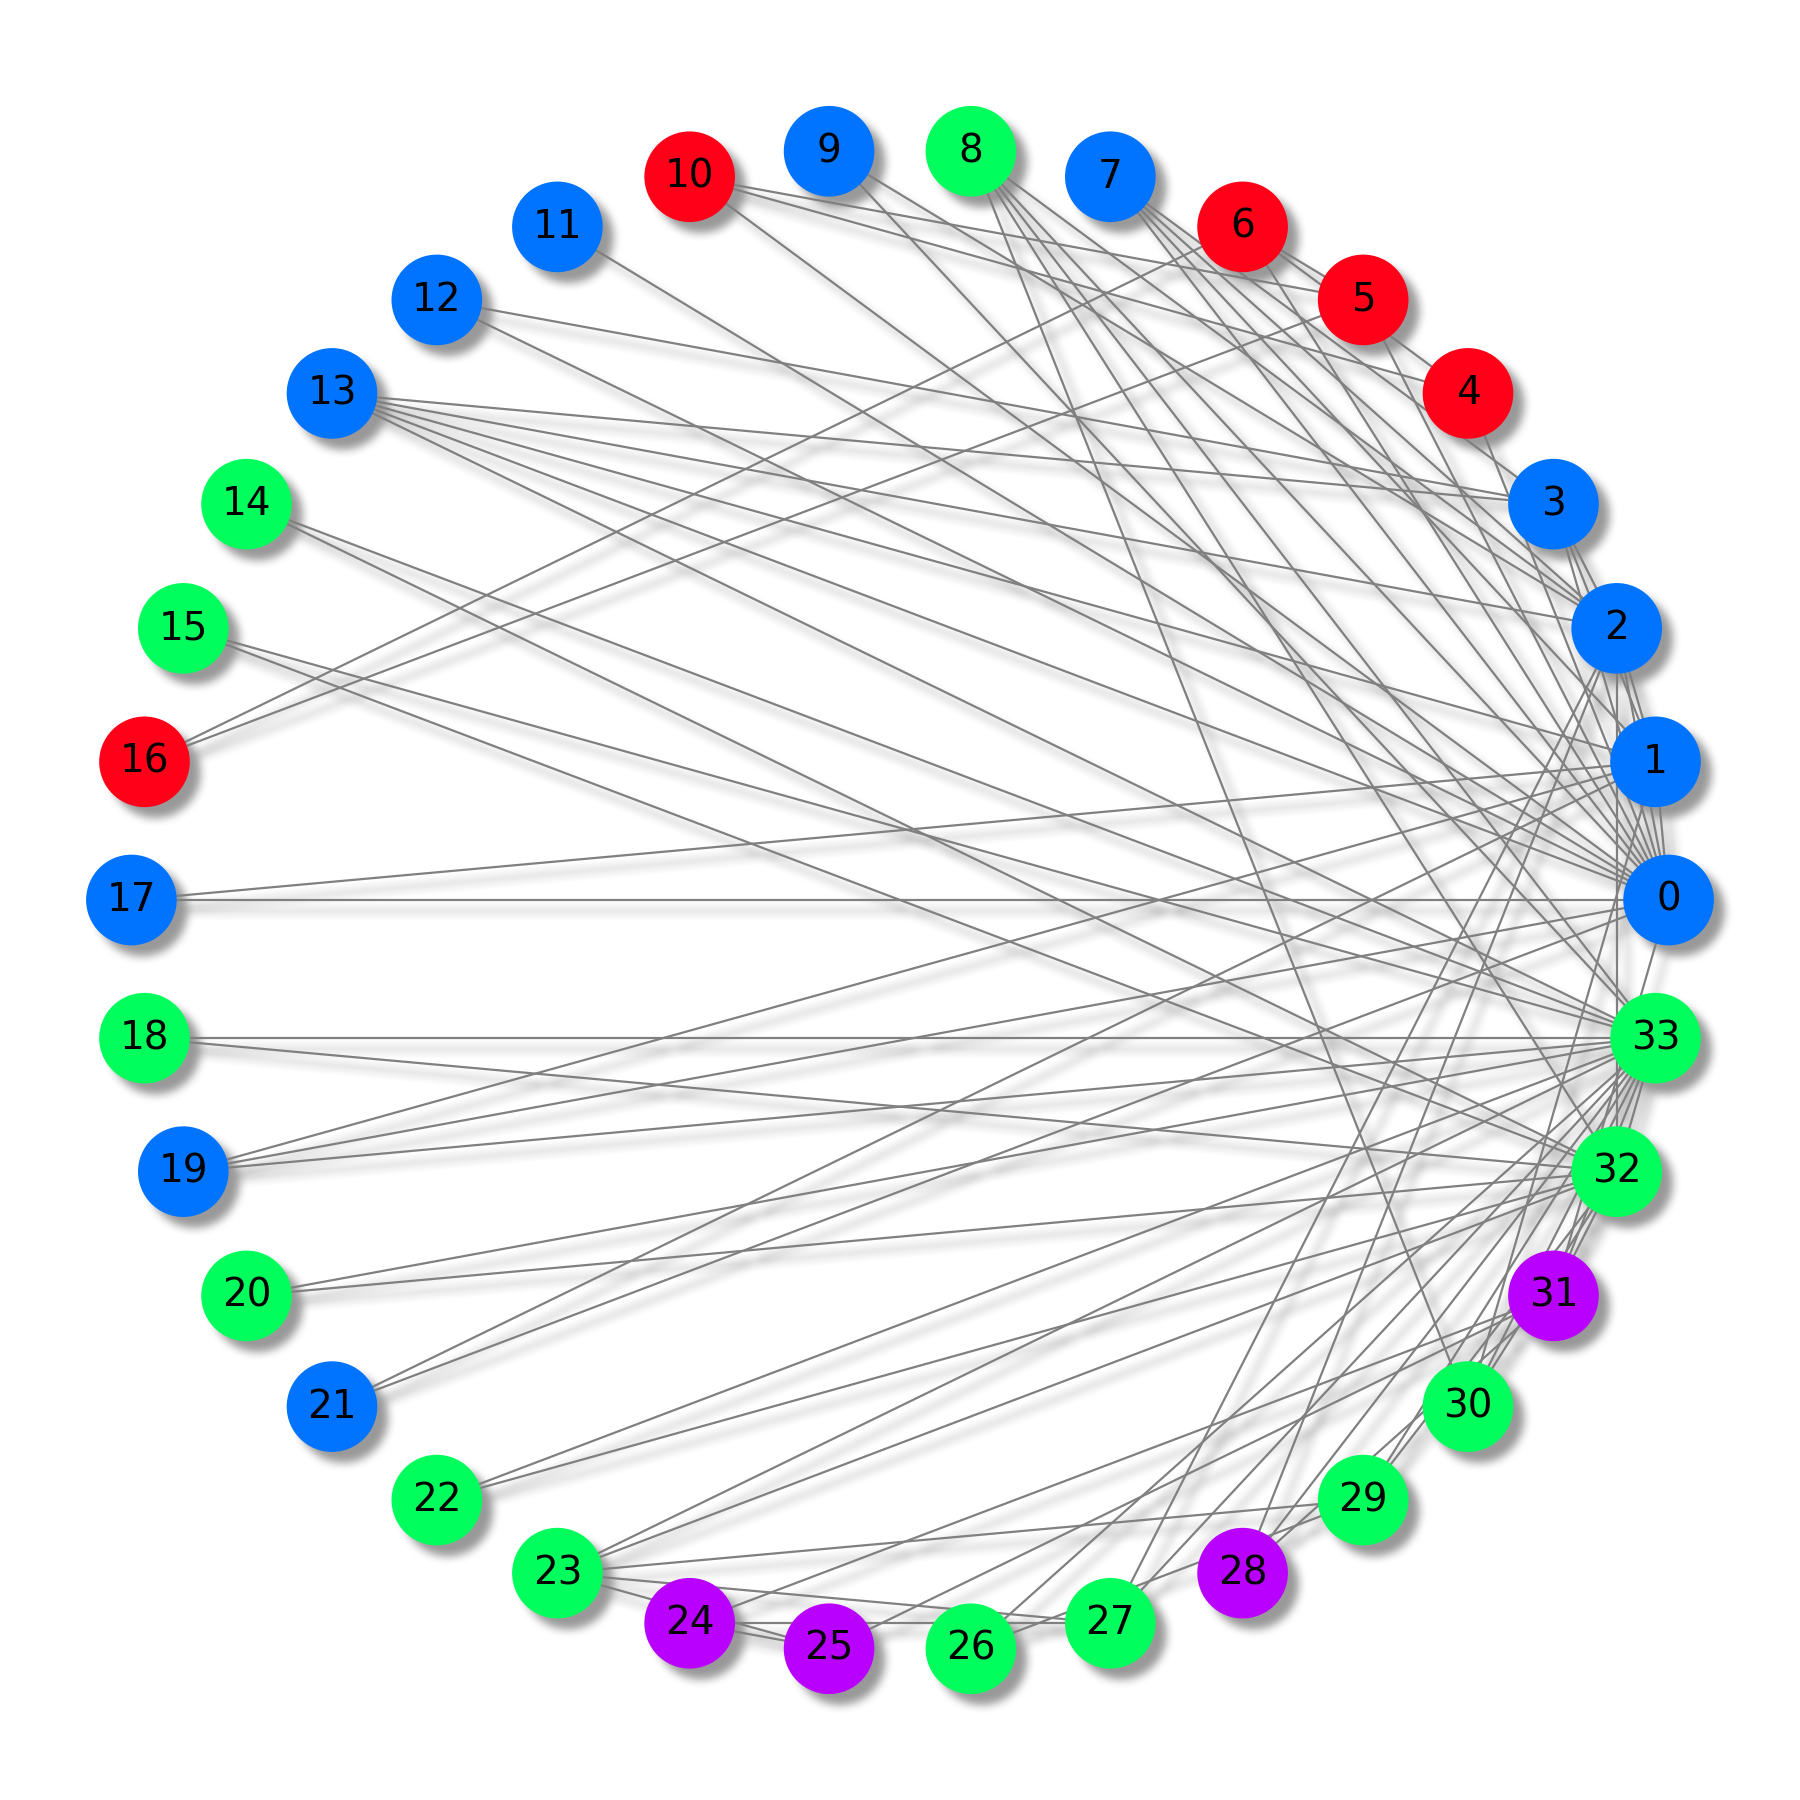

The nodes represent club members, and edges between them indicate interactions that occurred outside the club environment. The task is to assign each member to the correct group (a total of four groups) based on the interaction patterns.

In [2]:
dataset = KarateClub()

print(dataset)
print('---------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Graph: {dataset[0]}')

data = dataset[0]
print(f'x = {data.x.shape}')
print(data.x)

print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

print(f'y = {data.y.shape}')
print(data.y)

print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

KarateClub()
---------
Number of graphs: 1
Number of features: 34
Number of classes: 4
Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29,

* x = [34, 34] is the node feature matrix with shape (number of nodes, number of features). There are 34 nodes, each associated with a 34-dimensional feature vector.

* edge_index = [2, 156] represents the graph connectivity with shape (2, number of directed edges), stored in Coordinate List (COO) format for efficient sparse matrix storage.

* y = [34] contains the ground-truth labels for each node.

* train_mask = [34] is an optional attribute with boolean values indicating which nodes are designated for training.

In [3]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


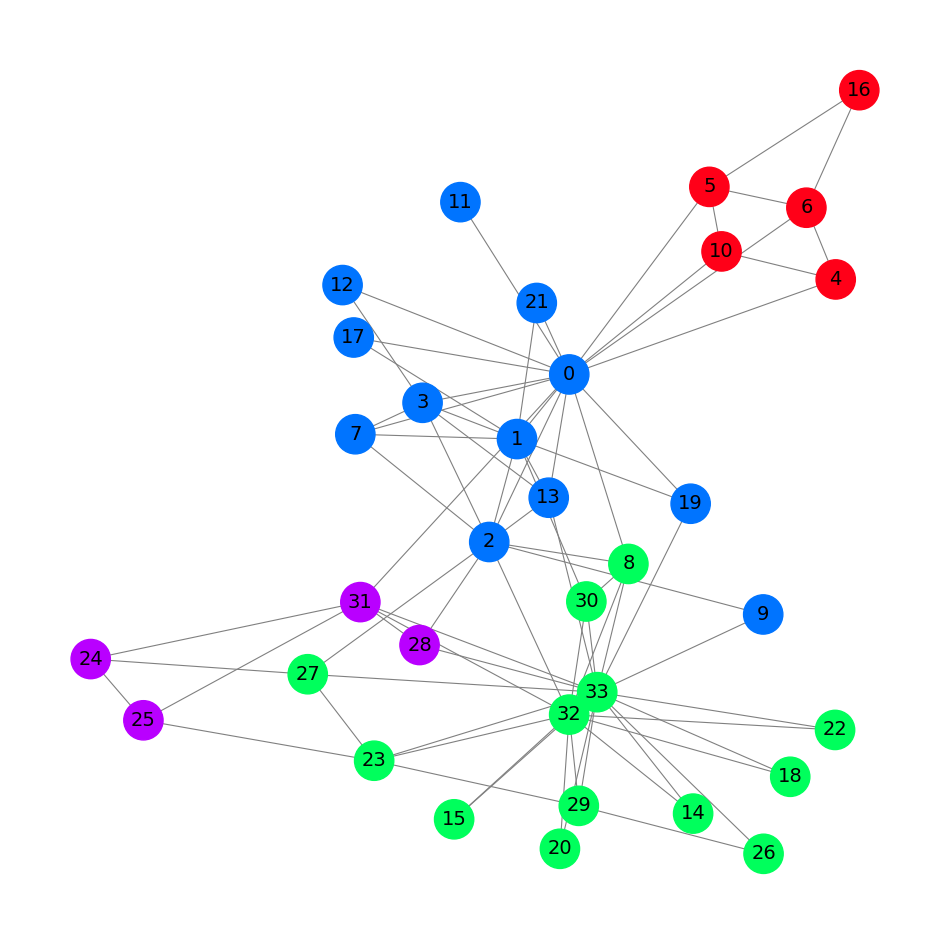

In [4]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12, 12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap='hsv',
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color='grey',
                font_size=14
                )
plt.show()

### GCN Embedding Update

#### Initial Embedding
For all $v \in V$:$h_v^{(0)} = x_v$
- $h_v^{(0)}$: Node $v$'s initial embedding
- $x_v$: Node $v$'s original features

#### Embedding Update at Each Step
For $k = 1, 2, \dots, K$:
$$
h_v^{(k)} = f^{(k)} \left( W^{(k)} \cdot \frac{\sum_{u \in \mathcal{N}(v)} h_u^{(k-1)}}{|\mathcal{N}(v)|} + B^{(k)} \cdot h_v^{(k-1)} \right)
$$
- $h_v^{(k)}$: Node $v$'s embedding at step $k$
- $\mathcal{N}(v)$: The set of neighbors of node $v$
- $h_u^{(k-1)}$: Embedding of neighbor $u$ of node $v$ at step $k-1$
- $W^{(k)}$ and $B^{(k)}$: (Potentially) learnable parameters
- $f^{(k)}$: A non-linear function

---

### Prediction at Each Node
Predictions can be made at each node by using the final computed embedding:
$$
\hat{y}_v = \text{PREDICT} \left( h_v^{(K)} \right)
$$
where **PREDICT** is generally another neural network, learned together with the GCN model.

---

### Notes on GCN Parameters
For each step $k$, the function $f^{(k)}$, matrices $W^{(k)}$, and $B^{(k)}$ are shared across all nodes. This allows the GCN model to scale well, because the number of parameters in the model is not tied to the size of the graph.

---

### Normalization Variant
The variant discussed here is the **2-parameter model** from the original paper, which is more expressive. We also consider the following normalization (iteration subscripts omitted):
$$
f \left( W \cdot \frac{\sum_{u \in \mathcal{N}(v)} h_u}{|\mathcal{N}(v)|} + B \cdot h_v \right)
$$
instead of the normalization defined in the original paper:
$$
f \left( W \cdot \frac{\sum_{u \in \mathcal{N}(v)} h_u}{\sqrt{|\mathcal{N}(u)||\mathcal{N}(v)|}} + B \cdot h_v \right)
$$
for ease of exposition.

In [5]:
class MyGCNConv(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super().__init__()
        
        self.weight = nn.Parameter(torch.randn(in_channels, out_channels))
        nn.init.xavier_uniform_(self.weight)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)
            
    def add_self_loops(self, edge_index, num_nodes):
        
        self_loops = torch.arange(0, num_nodes, dtype=torch.long, device=edge_index.device)
        self_loops = self_loops.unsqueeze(0).repeat(2, 1)
        edge_index = torch.cat((edge_index, self_loops), dim=1)
        
        return edge_index
    
    def forward(self, x, edge_index):
        # x: (num_nodes, in_channels)
        # edge_index: (2, num_edges)
        num_nodes = x.size(0)
        edge_index = self.add_self_loops(edge_index, num_nodes)
        
        # x: (num_nodes, out_channels)
        x = torch.mm(x, self.weight)
        # row, col: (num_edges,)
        row, col = edge_index
        
        # deg: (num_nodes,)
        deg = torch.bincount(row, minlength=num_nodes)
        deg_inv_sqrt = deg.float().pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        # agg: (num_nodes, out_channels)
        agg = torch.zeros_like(x)
        # temp_x: (num_nodes, out_channels)
        temp_x = x * deg_inv_sqrt.unsqueeze(1)
        agg.index_add_(0, row, temp_x[col] * deg_inv_sqrt[col].unsqueeze(1))
            
        if self.bias is not None:
            agg = agg + self.bias * x
            
        return agg

In [6]:
class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.gcn = MyGCNConv(dataset.num_features, 3)
        # self.gcn = GCNConv(dataset.num_features, 3)
        self.out = nn.Linear(3, dataset.num_classes)
        
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

In [7]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def accuracy(pred_y, y):
    return (pred_y == y).sum().float() / len(y)

for epoch in range(201):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.54 | Acc: 17.65%
Epoch  10 | Loss: 1.45 | Acc: 38.24%
Epoch  20 | Loss: 1.36 | Acc: 38.24%
Epoch  30 | Loss: 1.26 | Acc: 41.18%
Epoch  40 | Loss: 1.12 | Acc: 50.00%
Epoch  50 | Loss: 0.94 | Acc: 58.82%
Epoch  60 | Loss: 0.74 | Acc: 61.76%
Epoch  70 | Loss: 0.54 | Acc: 100.00%
Epoch  80 | Loss: 0.36 | Acc: 100.00%
Epoch  90 | Loss: 0.24 | Acc: 100.00%
Epoch 100 | Loss: 0.15 | Acc: 100.00%
Epoch 110 | Loss: 0.09 | Acc: 100.00%
Epoch 120 | Loss: 0.06 | Acc: 100.00%
Epoch 130 | Loss: 0.04 | Acc: 100.00%
Epoch 140 | Loss: 0.03 | Acc: 100.00%
Epoch 150 | Loss: 0.02 | Acc: 100.00%
Epoch 160 | Loss: 0.02 | Acc: 100.00%
Epoch 170 | Loss: 0.02 | Acc: 100.00%
Epoch 180 | Loss: 0.01 | Acc: 100.00%
Epoch 190 | Loss: 0.01 | Acc: 100.00%
Epoch 200 | Loss: 0.01 | Acc: 100.00%


If we add a second GCN layer, our model would aggregate feature vectors not only from each node’s immediate neighbors but also from neighbors of those neighbors. However, adding too many layers can lead to excessive aggregation, where all node embeddings converge to similar values, a phenomenon known as over-smoothing (not "over-shooting").